In [1]:
# Custom functions
from my_functions import *
# Import data:
import pickle
# ML packages:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer, MultiLabelBinarizer
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, ShuffleSplit
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from xgboost import XGBClassifier

In [2]:
# Import Pickled data
infile = open('bk_data_merged','rb')
df_merge = pickle.load(infile)
infile.close()
print(len(df_merge))

269


## 1) Sentiment Analysis
#### Labelling the reviews 
We will use the original (un-untransformed) reviews attribute for the sentiment analysis

In [3]:
# Determine Sentiment of Reviews (Hutto, n.d.)
df_merge['sentiment'] = df_merge['review'].apply(lambda x: sid_analyser(x, True))
df_merge['sentiment_all'] = df_merge['review'].apply(lambda x: sid_analyser(x, False))

# Split overall scores into separate columns for plotting
df_merge['sentiment_pos'] = df_merge['sentiment'].apply(lambda x: x['pos'])
df_merge['sentiment_neg'] = df_merge['sentiment'].apply(lambda x: x['neg'])
df_merge['sentiment_neu'] = df_merge['sentiment'].apply(lambda x: x['neu'])
df_merge['sentiment_comp'] = df_merge['sentiment'].apply(lambda x: x['compound'])

# Apply overall sentiment classification label
df_merge['sentiment_overall'] = df_merge['sentiment'].apply(lambda x: sentiment_overall(x['compound']))

df_merge.head(2)

,title,year,genre,movie_description,critical_consensus,review,sentiment,sentiment_all,sentiment_pos,sentiment_neg,sentiment_neu,sentiment_comp,sentiment_overall
0,The Hunger Games: Catching Fire,2013,"[Adventure, Sci-Fi, Action]",After arriving safely home from their unpreced...,"Smart, smoothly directed, and enriched with a ...","[Catching Fire delivers on the grim, roiling p...","{'neg': 0.105, 'neu': 0.65, 'pos': 0.246, 'com...","[{'neg': 0.339, 'neu': 0.389, 'pos': 0.272, 'c...",0.246,0.105,0.650,0.9986,positive
1,The Hunger Games: Mockingjay – Part 1,2014,"[Action, Adventure, Sci-Fi]",Following her rescue from the devastating Quar...,The Hunger Games: Mockingjay - Part 1 sets up ...,"[""Mockingjay - Part 1,"" however well done, can...","{'neg': 0.039, 'neu': 0.771, 'pos': 0.19, 'com...","[{'neg': 0.0, 'neu': 0.764, 'pos': 0.236, 'com...",0.190,0.039,0.771,0.9974,positive


In [4]:
# Note the data are imbalanced
df_merge['sentiment_overall'].value_counts()

positive    233
negative     35
neutral       1
Name: sentiment_overall, dtype: int64

Text(0.5, 1.0, 'Compound Sentiment')

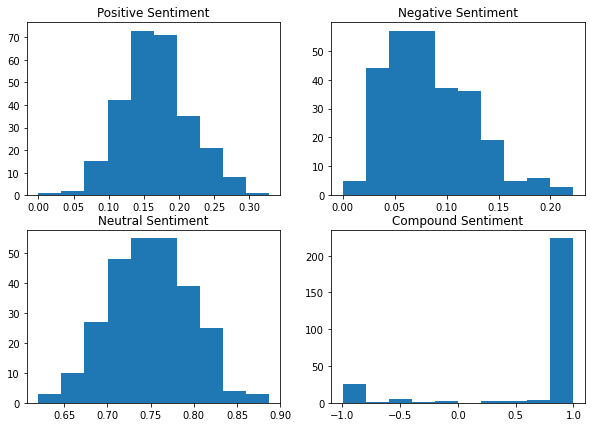

In [5]:
fig, axs = plt.subplots(2, 2, figsize = (10,7))

# Plot the distribution of sentiment
axs[0,0].hist(df_merge['sentiment_pos'])
axs[0,0].set_title("Positive Sentiment")
axs[0,1].hist(df_merge['sentiment_neg'])
axs[0,1].set_title("Negative Sentiment")
axs[1,0].hist(df_merge['sentiment_neu'])
axs[1,0].set_title("Neutral Sentiment")
axs[1,1].hist(df_merge['sentiment_comp'])
axs[1,1].set_title("Compound Sentiment")

**What is the neutral review?**

It looks like the reviews are balanced between positive and negative. As this is the only film that VADER has classified as neutral, we will remove it from the dataset.

In [6]:
# What is the neutral review?
print('Film: ', df_merge[df_merge['sentiment_overall'] == 'neutral']['title'].values)

Film:  ['Thunderball']


In [7]:
# How are the reviews scored individually?
df_merge.head()

sent = []
for i in list(df_merge[df_merge['sentiment_overall'] == 'neutral']['sentiment_all'])[0]:
    sent.append([i['compound'], sentiment_overall(np.mean(i['compound']))])
    
pd.DataFrame(sent)[1].value_counts()

positive    5
negative    3
Name: 1, dtype: int64

In [8]:
# Re-classify as positive
df_merge.loc[df_merge.title == 'Thunderball', 'sentiment_overall'] = 'positive'

In [9]:
# Note the data are imbalanced
df_merge['sentiment_overall'].value_counts()

positive    234
negative     35
Name: sentiment_overall, dtype: int64

## 2) Construct final data model
### Data Cleanup

In [ ]:
# Clean text
# 1) Remove non-letters
# 2) Remove stop words for descriptions and reviews
# 3) Lemmatize text for descriptions and reviews
df_merge['movie_description'] = df_merge['movie_description'].apply(lambda x: clean_text(x, True)) 
df_merge['critical_consensus'] = df_merge['critical_consensus'].apply(lambda x: clean_text(x, True))
df_merge['review_list'] = df_merge['review'].apply(lambda x: clean_text_list(x, True)) 
df_merge['reviews'] = df_merge['review_list'].apply(lambda x: ', '.join(x))

# Convert genre to lower case
df_merge['genre'] = df_merge['genre'].apply(lambda x: '| '.join(x).lower().split('| '))

df_merge.head(3)

In [ ]:
# Top 50 frequently used words for movie descriptions
freq_words_chart(df_merge['movie_description'], 50, 'Description', 4)

In [ ]:
# Top 50 frequently used words for reviews
freq_words_chart(df_merge['reviews'], 50, 'Reviews', 4)

In [ ]:
# Top 50 frequently used words for critical consensus
freq_words_chart(df_merge['critical_consensus'], 50, 'critical_consensus', 4)

In [ ]:
# Word count distribution for movie descriptions
des_len = df_merge['movie_description'].apply(lambda x: len(x))
sns.histplot(des_len)
plt.title('Description word count distribution')

In [ ]:
# Word count distribution for reviews
rev_len = df_merge['reviews'].apply(lambda x: len(x))
sns.histplot(rev_len)
plt.title('Review word count distribution')

In [ ]:
# Word count distribution for critical consensus
rev_len = df_merge['critical_consensus'].apply(lambda x: len(x))
sns.histplot(rev_len)
plt.title('Review word count critical_consensus')

#### Final Dataframe
Remove columns:
* **review:** original review data
* **worldwide_gross**: not important for this model
* **review_list:** list of cleaned review data
* **sentiment_overall, sentiment_all, sentiment_pos, sentiment_neg, sentiment_neu, sentiment_comp:** we only need sentiment 

In [ ]:
df_model = df_merge.copy()

# Binary label for overall sentiment
df_model['sentiment']=df_model['sentiment_overall'].apply(lambda x: 1 if x=='positive' else 0)

# Merge title and year columns
df_model['title'] = df_model.apply(lambda x: x.title + ' (' + str(x.year) + ')', axis = 1)

# Concatenate X variables
df_model['text'] = (df_model["movie_description"].astype(str)
                    .str.cat(df_model["critical_consensus"], sep =" ")
                    .str.cat(df_model["reviews"], sep =" ")
                    ).str.strip()

# Select columns for final DataFrame
cols = ['title', 'genre', 'sentiment', 'text']
df_model = df_model.loc[:, cols]

df_model.head(3)

In [ ]:
print('Number of films to model: ',len(df_model))

### Data Wrangling for Model

In [ ]:
# Multilabel Binarizer - applied on y (target) variable
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(df_model['genre'])

# transform target variable
y = multilabel_binarizer.transform(df_model['genre'])

# Transform text to non-numeric form using a TFIDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features = 1500)

# Split into training and test data sets
X = df_model ['text']
X_train, X_test, y_train, y_test = train_test_split(X
                                                    , y
                                                    , test_size = 0.2
                                                    , random_state = 0)

# Store an unaltered copy of the test data for recommender system demonstration
X_test_copy = X_test.copy()

# Create TF-IDF features
X_train = tfidf_vectorizer.fit_transform(X_train)
X_test = tfidf_vectorizer.transform(X_test)

# Normalise X data sets
norm = Normalizer()
X_train = norm.fit_transform(X_train)
X_test  = norm.transform(X_test)

### Build the Recommender System using the XGBoost Classifier

In [ ]:
# Create the hyperparameter grid
xg_params = {
    "estimator__max_depth": [1, 3, 5, 7, 9],
    "estimator__learning_rate": [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
    "estimator__n_estimators":  [100, 200, 400, 600, 800, 1000],
    "estimator__colsample_bytree": [0.3, 0.5, 0.7],
    "estimator__gamma": [0, 1, 5],
    "estimator__subsample": [0.5 ,0.7 ,1]
}

xg_params

In [ ]:
%%time

# Construct XGBoost Classifier wrapped that use OVR
xgc = OneVsRestClassifier(XGBClassifier(random_state = 1, verbosity  = 0, use_label_encoder=False, n_jobs = -1))

# Search across 50 random combinations from the hyperparameter grid
clf_xgc_random = RandomizedSearchCV(estimator = xgc
                               , param_distributions = xg_params
                               , n_iter = 50
                               , cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
                               , verbose=0
                               , random_state=1
                               , n_jobs = -1
                               , scoring = 'f1_micro'
                               , return_train_score = True)

# Fit the random model to find the best hyperparameter values
clf_xgc_random.fit(X_train, y_train)

In [ ]:
# Best hyperparameter values
best_params = clf_xgc_random.best_params_
clf_xgc_random.best_params_

In [ ]:
%%time
# Fit final model with best hyperparameter values
xg_final = OneVsRestClassifier(XGBClassifier( max_depth = best_params['estimator__max_depth']
                       , learning_rate = best_params['estimator__learning_rate']
                       , n_estimators = best_params['estimator__n_estimators']
                       , gamma = best_params['estimator__gamma']
                       , subsample = best_params['estimator__subsample']
                       , n_jobs = -1
                       , random_state = 1 
                       , use_label_encoder=False
                       , verbosity  = 0))
xg_final.fit(X_train, y_train )

In [ ]:
%%time

# Cross validated metrics
def cv_score (score, cv):
    return cross_val_score(xg_final
                        , X_train
                        , y_train
                        , cv = cv
                        , scoring = score
                        , verbose = 0
                        , n_jobs = -1)

scores_lst = []
for i in ["accuracy","f1_micro", "recall_micro", "precision_micro", "roc_auc"]:
    scores_lst.append(cv_score(i, 10))

In [ ]:
# Cross validated results
cv_scores_xg = pd.DataFrame(scores_lst).transpose()
cv_scores_xg.columns = ["accuracy","f1_score", "recall_score", "precision_score", "roc_auc"]
cv_scores_xg = pd.DataFrame(cv_scores_xg.mean()).transpose()

In [ ]:
# Performance on training data
y_pred_xg = xg_final.predict(X_train)
train_scores_xg = pd.DataFrame.from_dict({'accuracy' : accuracy_score(y_train, y_pred_xg)
                                 , 'f1_score': f1_score(y_train, y_pred_xg, average="micro")
                                 , 'recall_score': recall_score(y_train, y_pred_xg, average="micro")
                                 , 'precision_score': precision_score(y_train, y_pred_xg, average="micro")
                                 , 'roc_auc': roc_auc_score(y_train, y_pred_xg, average="micro")
                                }, orient = 'index').transpose()

In [ ]:
# Performance on Test data
y_pred_xg_fin = xg_final.predict(X_test)
test_scores_xg = pd.DataFrame.from_dict({'accuracy' : accuracy_score(y_test, y_pred_xg_fin)
                                 , 'f1_score': f1_score(y_test, y_pred_xg_fin, average="micro")
                                 , 'recall_score': recall_score(y_test, y_pred_xg_fin, average="micro")
                                 , 'precision_score': precision_score(y_test, y_pred_xg_fin, average="micro")
                                 , 'roc_auc': roc_auc_score(y_test, y_pred_xg_fin, average="micro")
                                }, orient = 'index').transpose()

In [ ]:
# Dataframe of model performance across CV, training and test
scores_xg = pd.concat([train_scores_xg, cv_scores_xg, test_scores_xg])
scores_xg['Scores'] = ['Training', 'CV', 'Test']
scores_xg.set_index(['Scores'])

## Example use of the recommender system
### Model's predictions

In [ ]:
# Look up a selected genre:
genre = 'action'

# Search for selected genre in the predicted genres
idx_lst = []
n = 0
for i in multilabel_binarizer.inverse_transform(y_pred_xg_fin):
    if any([word in genre for word in list(i)]):
        idx_lst.append(n)
    n += 1

# Lookup reference for original film name
x_text_ref = pd.DataFrame(X_test_copy).reset_index()

# Print out predicted genres against real genres
print('Number of films found: ', len(idx_lst))
for i in idx_lst:
    idx = x_text_ref.loc[x_text_ref.index == i, 'index'].values[0]
    
    print ('Film: ', df_model.loc[idx,'title'] )
    print ('Sentiment of reviews: ', np.where(df_model.loc[idx,'sentiment'] == 1, 'positive', 'negative'))
    print ('Genre(s): ', multilabel_binarizer.inverse_transform(y_test)[i])
    print ('Prediction: ', multilabel_binarizer.inverse_transform(y_pred_xg_fin)[i])
    print ('------')

### Actual results in the test data

In [ ]:
# Look up a selected genre:
genre = 'action'

# Search for selected genre in the predicted genres
idx_lst = []
n = 0
for i in multilabel_binarizer.inverse_transform(y_test):
    if any([word in genre for word in list(i)]):
        idx_lst.append(n)
    n += 1

# Lookup reference for original film name
x_text_ref = pd.DataFrame(X_test_copy).reset_index()

# Print out predicted genres against real genres
print('Number of films found: ', len(idx_lst))
for i in idx_lst:
    idx = x_text_ref.loc[x_text_ref.index == i, 'index'].values[0]
    
    print ('Film: ', df_model.loc[idx,'title'] )
    print ('Sentiment of reviews: ', np.where(df_model.loc[idx,'sentiment'] == 1, 'positive', 'negative'))
    print ('Genre(s): ', multilabel_binarizer.inverse_transform(y_test)[i])
    print ('Prediction: ', multilabel_binarizer.inverse_transform(y_pred_xg_fin)[i])
    print ('------')